In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/train/ffbf75e5b.jpg
/kaggle/input/global-wheat-detection/train/cce5cb631.jpg
/kaggle/input/global-wheat-detection/train/0679b8bab.jpg
/kaggle/input/global-wheat-detection/train/4c5805bae.jpg
/kaggle/input/global-wheat-detection/train/2474376a6.jpg
/kaggle/input/global-wheat-detection/train/8de789df8.jpg
/kaggle/input/global-wheat-detection/train/9ab4727a2.jpg
/kaggle/input/global-wheat-detection/train/f3c5e09ab.jpg
/kaggle/input/global-wheat-detection/train/e3732d7b7.jpg
/kaggle/input/global-wheat-detection/train/9c05c8d56.jpg
/kaggle/input/global-wheat-detection/train/9d78cb5d0.jpg
/kaggle/input/global-wheat-detection/train/1b547b682.jpg
/kaggle/input/global-wheat-detection/train/7d5af5b74.jpg
/kaggle/input/global-wheat-detection/train/2bfadaa91.jpg
/kaggle/input/global-wheat-detection/train/9b260d538.jpg
/kaggle/input/global-wheat-detection/tr

In [2]:
import cv2
import os
import re

# Imports for image transforms
# Albumentations bounding box augmentation docs: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Torch imports
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
INPUT_DIR = '/kaggle/input/global-wheat-detection'
# PRETRAINED_DIR = '/kaggle/input/wheat-dataset-project'
PRETRAINED_DIR = '/kaggle/input/wheat-frcnn-bayesian/'
OUTPUT_DIR = '/kaggle/output/'
TRAIN_DIR = f'{INPUT_DIR}/train'
TEST_DIR = f'{INPUT_DIR}/test'
# MODEL_LOC = f'{PRETRAINED_DIR}/fasterrcnn_resnet50_fpn_TRAINED.pth'
MODEL_LOC = f'{PRETRAINED_DIR}/fasterrcnn_resnet50_fpn_BAYESOPT.pth'

# Model Inference
* Create TestDataset class (similar to WheatDataset but no bboxes, transforms only change to tensor)
* Create dataset using TestDataset clas
* Create dataloader
* Loop over images, image_ids in dataloader
    * Within each iteration, get outputs by calling model(images)
    * Loop over i, image in enum(images)
        * Get boxes and scores from outputs for element i
        * Threshold boxes and scores
        * Get boxes from \[xmin ymin xmax ymax\] form into \[x y w h\] form
        * make result dict for image id and prediction string (in competition format) and append to result list
* Sample from outputs as before (with score threshold on boxes) to display prediction

In [5]:
def test_transform():
    return A.Compose([ToTensorV2(p=1.0)])

class TestDataset(Dataset):
    
    def __init__(self, df, directory, transforms=None):
        super().__init__()
        
        self.image_ids = df['image_id'].unique()
        self.df = df
        self.dir = directory
        self.transforms = transforms
        
    def __len__(self):
        return int(self.image_ids.shape[0])
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # cv2 reads images into BGR format, must convert to RGB for f-RCNN
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # f-RCNN requires images in [C,W,H] form with values in [0,1]
        image /= 255.0
        
        if self.transforms:
            dataToTransform = {'image': image}
            transData = self.transforms(**dataToTransform)
            image = transData['image']
        
        return image, image_id

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
pretrained_state_dict = torch.load(MODEL_LOC)
model.load_state_dict(pretrained_state_dict)
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [7]:
test_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
test_df.head()

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50


In [8]:
test_df.shape

(10, 2)

In [9]:
test_dataset = TestDataset(test_df, TEST_DIR, test_transform())

def collate_fn(batch):
    return tuple(zip(*batch))

test_dl = DataLoader(dataset=test_dataset, batch_size=4, num_workers=4, collate_fn=collate_fn)

In [10]:
THRESHOLD = .5
res = []

def getPredString(outputTup):
    formatted_strings = []
    for tup in outputTup:
        score = tup[0]
        x, y, w, h = tup[1]
        box_string = f'{score} {x} {y} {w} {h}'
        formatted_strings.append(box_string)
    return " ".join(formatted_strings)
    
    

for imgs, img_ids in test_dl:
    imgs = list(image.to(device) for image in imgs)
    model_outputs = model(imgs)
    
    for i,img in enumerate(imgs):
        scores = model_outputs[i]['scores'].data.cpu().numpy()
        bboxes = model_outputs[i]['boxes'].data.cpu().numpy()
        bboxes = bboxes[scores >= THRESHOLD].astype(np.int32)
        scores = scores[scores >= THRESHOLD]
        
        this_id = img_ids[i]
        
        bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
        bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
        
        res.append({'image_id': this_id, 'PredictionString': getPredString(zip(scores, bboxes))})

test_df = pd.DataFrame(res, columns=['image_id', 'PredictionString'])

/opt/conda/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [11]:
test_df.head(10)

,image_id,PredictionString
0,aac893a91,0.9904304146766663 616 914 77 109 0.9877975583...
1,51f1be19e,0.9948440790176392 606 85 164 179 0.9899553060...
2,f5a1f0358,0.9949111342430115 57 456 154 142 0.9895849823...
3,796707dd7,0.9876222014427185 894 330 109 92 0.9864115715...
4,51b3e36ab,0.9970691800117493 532 25 264 141 0.9962388277...
5,348a992bb,0.9958398342132568 734 221 138 88 0.9949989318...
6,cc3532ff6,0.9968180656433105 74 807 144 171 0.9964900612...
7,2fd875eaa,0.9971019625663757 457 496 82 134 0.9970288872...
8,cb8d261a3,0.994767427444458 15 554 190 112 0.98128956556...
9,53f253011,0.9977237582206726 465 453 160 214 0.997681975...


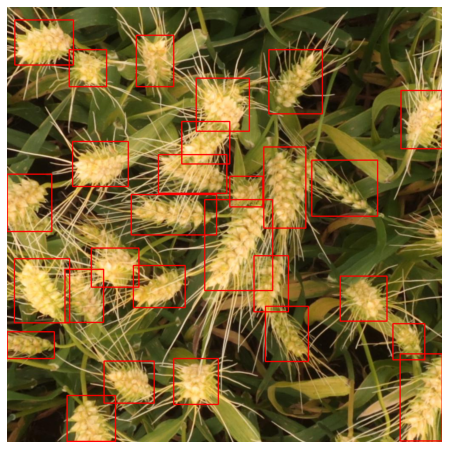

In [12]:
sample = imgs[1].permute(1,2,0).cpu().numpy()
scores = model_outputs[1]['scores'].data.cpu().numpy()
bboxes = model_outputs[1]['boxes'].data.cpu().numpy()
bboxes = bboxes[scores >= THRESHOLD].astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in bboxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [13]:
test_df.to_csv('submission.csv', index=False)